# Introduction

The client is a small startup focusing on fraud detection, sentiment classification, customer intention prediction, and classification. They asked to build a robust machine learning system that leverages information coming from call center data and improves the success rate for calls made to customers for any product that our clients offer. 

The clients asked to: 

1. build a model that is at least 81% accurate in predicting subscription to a term deposit
2. determine the segment(s) of customers to prioritize.
3. identify the feature(s) that play a major role in leading clients to buy the term deposition subscription.

# Libraries

In [36]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # the sklearn GradientBoosting models are reported less performative than the xgboost ones
from sklearn.svm import SVC #support vector classifier

# accuracy metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split

# Data exploration

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure subscription to a term deposit, i.e. short-term deposits with maturities ranging from one month to a few years. All customer information that might reveal personal information is removed due to privacy concerns.

In [2]:
data = pd.read_csv("../data/raw/term-deposit-marketing-2020.csv")
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


### Pre-processing

#### Missing values

There is no missing value in the dataset.

In [82]:
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

#### Category encoding

However, some pre-processing needs to be done since the features are both numeric (continuous) and categorical:

- `age` : age of customer (numeric)
- `job` : type of job (categorical)
- `marital` : marital status (categorical)
- `education` (categorical)
- `default`: has credit in default? (binary)
- `balance`: average yearly balance, in euros (numeric)
- `housing`: has a housing loan? (binary)
- `loan`: has personal loan? (binary)
- `contact`: contact communication type (categorical)
- `day`: last contact day of the month (numeric)
- `month`: last contact month of year (categorical)
- `duration`: last contact duration, in seconds (numeric)
- `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- `y`: target label, has the client subscribed to a term deposit? (binary)

Here's a break down on the unique values for each of the 9 categorical columns, and the observation count for each:

In [4]:
for i in range(len(data.columns)):
    if data[data.columns[i]].dtypes != 'int64':
        print(data[data.columns[i]].value_counts(), '\n')

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64 

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64 

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64 

no     39191
yes      809
Name: default, dtype: int64 

yes    24031
no     15969
Name: housing, dtype: int64 

no     33070
yes     6930
Name: loan, dtype: int64 

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64 

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64 

no     37104
yes     2896
Name: y, dtype: int64 



We have two main different kinds of categorial variables:

- interval categories (roughly equal magnitude between values): `education` (4), `month` (11)
- nominal categories (without a particular order, and with a cardinality < 15):
  - binary categories: `default`, `housing`, `loan`, `y`
  - non-binary categories: `job` (12), `marital` (3), `contact` (3)
 
Different categorical encoding techniques will be applied for each case.

For the interval categories, ordinal encoding will be applied. I will not use the `OrdinalEncoder` function from `sklearn`, but I will manually encode the two variables, so ensure readibility even after encoding.

In [5]:
months = ['none', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
months_zip = dict(zip(months, range(int(len(months)))))
education_levels = ['unknown', 'primary', 'secondary', 'tertiary']
education_levels_zip = dict(zip(education_levels, range(int(len(education_levels)))))

data_ = data.replace({'month': months_zip, 'education': education_levels_zip}) # rename the dataset

For the binary categories, we will just use a standard label encoder, where yes is 1, and no is 0. Similarly to above will manually encode categories here as well.

In [6]:
binary_values = {'yes': 1, 'no': 0}
data_ = data_.replace({'default': binary_values, 'housing': binary_values, 'loan': binary_values, 'y': binary_values})

Finally, for non-binary nominal categories I will use frequency encoding, which encodes categorical feature values to their frequencies. This primarily ensures that the distributional information is preserved even after enconding. Moreoever, it may highlight some insights regarding the contribution to the categories onto the target label.

In [7]:
freq_columns = ['job', 'marital', 'contact']

for i in freq_columns:
    freq_encoder = (data_.groupby(i).size()) / len(data)
    data_[i] = data_[i].apply(lambda x: freq_encoder[x])

This is what the new dataset looks like: 

In [8]:
data_.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,0.204150,0.609650,3,0,2143,1,0,0.319125,5,5,261,1,0
1,44,0.171300,0.272225,2,0,29,1,0,0.319125,5,5,151,1,0
2,33,0.035125,0.609650,2,0,2,1,1,0.319125,5,5,76,1,0
3,47,0.234575,0.609650,0,0,1506,1,0,0.319125,5,5,92,1,0
4,33,0.005875,0.272225,0,0,1,0,0,0.319125,5,5,198,1,0


#### Imbalanced data

Finally, the original dataset suffers from a serious imbalance problem with one class ('no') being a lot more frequent that the other class ('yes')

In [9]:
data_['y'].value_counts(normalize=True).multiply(100)

0    92.76
1     7.24
Name: y, dtype: float64

<Axes: >

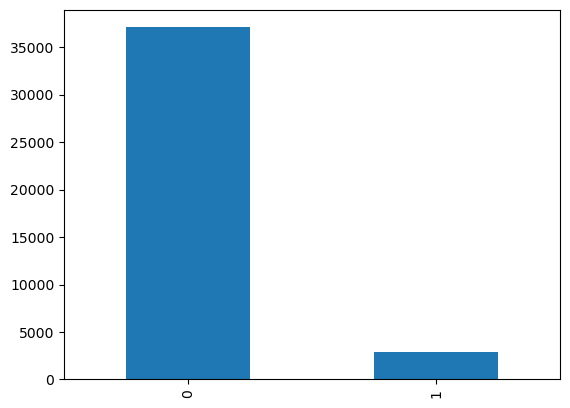

In [10]:
data_['y'].value_counts().plot.bar()

I will adopt the SMOTE procedure, a standard and widely used oversampling procedure, which essentially interpolates additional points in the class with less values (in this case, the `yes`-class) via KNN.

In [11]:
smote = SMOTE(random_state=42)

data_x = data_.drop(['y'], axis=1)
data_y = data_['y']

data_x_smote, data_y_smote = smote.fit_resample(data_x, data_y)

Here's a comparison between the old and new datasets:

In [12]:
# Before SMOTE
data_y.value_counts(normalize=True).multiply(100)

0    92.76
1     7.24
Name: y, dtype: float64

In [13]:
# After SMOTE
data_y_smote.value_counts(normalize=True).multiply(100)

0    50.0
1    50.0
Name: y, dtype: float64

<Axes: >

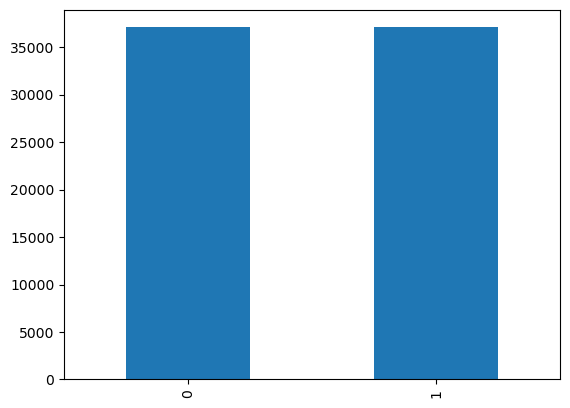

In [14]:
data_y_smote.value_counts().plot.bar()

#### Feature selection

Finally, I will perform feature selection by looking at both correlation among features and with the target label, and the Fisher score.

<Axes: >

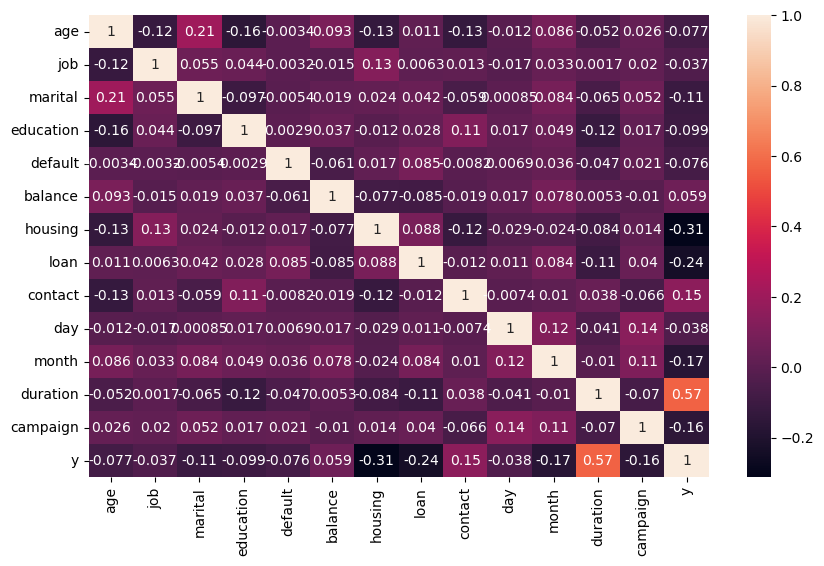

In [15]:
# correlations
data_correlation = pd.concat([data_x_smote, data_y_smote], axis=1)
corr = data_correlation.corr()

plt.figure(figsize = (10,6))
sns.heatmap(corr, annot=True)

The correlation heatmap suggests no major collinearity issue among the features. However, it suggests that some features may be more correlated with the target label than others. So to speed up training, I will remove the features whose correlation with `y` is higher than -0.1 and less than +0.1. 

In [18]:
features_to_remove = corr.loc[:, abs(corr.loc['y']) < abs(0.1)].columns
data_x_smote_sel = data_x_smote.drop(features_to_remove, axis=1)

print("The features removed are:" + str(features_to_remove))

The features removed are:Index(['age', 'job', 'education', 'default', 'balance', 'day'], dtype='object')


I will be using this final dataset for model selection and hyperparameter tuning. The final dataset may be found in the relative folder.

In [19]:
X = data_x_smote_sel
y = data_y_smote

data_final = pd.concat([data_x_smote, data_y_smote], axis=1)
data_final.to_csv('../data/processed/dataset_final.csv', index=False)

# Modeling

Here's the algorithms we will try:

- logistic regression
- decision tree
- random forest
- XGboost
- SVM
- KNN

standard scaler/normalizer!!

First off, let's split our dataset into training and test sets:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scaling

Then, the feature must be before being given to any algorithm, so to ensure better accuracy. Only numerical variables (i.e., `duration`) will be scaled via standardization. Moreover, scaling will *only* be fit onto the training features, and then applied to both the training and test features, so to avoid data leakage.

In [25]:
columns_to_scale = ['duration']

# make a copy of both feature datasets
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

for i in columns_to_scale:
    # standardization, i.e. (X - Xmean)/(Xsd)
    standardization = StandardScaler().fit(X_train[[i]])

    X_train_stand[i] = standardization.transform(X_train[[i]])
    X_test_stand[i] =  standardization.transform(X_test[[i]])

In [26]:
X_train_stand

,marital,housing,loan,contact,month,duration,campaign
72879,0.452619,1,0,0.622850,4,-0.213307,1
32825,0.609650,1,0,0.622850,4,-0.615021,2
712,0.609650,1,0,0.319125,5,-0.880350,3
70772,0.390330,0,0,0.622850,5,-0.190990,1
41000,0.609650,0,0,0.622850,4,-0.292658,1
...,...,...,...,...,...,...,...
37194,0.609650,1,1,0.622850,5,-0.900188,1
6265,0.272225,1,0,0.319125,5,-0.897708,2
54886,0.272225,0,0,0.340765,5,-0.743966,1
860,0.609650,0,0,0.319125,5,-0.840674,1


#### Model selection and hyperparameter tuning via GridSearchCV

In [38]:
# setting up the parameter grid for the hyperparameter tuning

models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier', 
          'KNeighborsClassifier', 'SVC']
param_grid = dict().fromkeys(models)

param_grid['LogisticRegression'] = {'C': [1/0.0001, 1/0.001, 1/0.01, 1/0.1]} #inverse of regularization: 1/lambda

param_grid['DecisionTreeClassifier'] = {'criterion': ['entropy', 'gini'], # measure of impurity
                                        'max_depth': np.arange(1, len(X_train_stand.columns), 1), # how many levels does the tree have?
                                        'min_samples_split': [3, 4, 5], # how many samples are needed to make a split?
                                        'ccp_alpha': np.arange(0, 0.040, 0.005)# cost-complexity pruning
                                       }

param_grid['RandomForestClassifier'] = {'n_estimators': [30, 50, 75, 100, 150, 200], # number of trees in the forest
                                        'max_depth': np.arange(1, len(X_train_stand.columns), 1), # how many levels does the tree have?
                                        'min_samples_split': [3, 4, 5], # how many samples are needed to make a split?
                                        'warm_start': ['True', 'False']
                                       } 

param_grid['XGBClassifier'] = {'n_estimators': [30, 50, 75, 100, 150, 200], # number of trees in the forest
                               'reg_lambda': [0.0001, 0.001, 0.01, 0.1], # L2 regularization term
                               'booster': ['gbtree', 'gblinear', 'dart'] 
                            }

param_grid['KNeighborsClassifier'] = {'n_neighbors' : np.arange(5, 35, 5)} # how many neighbors should be group together? 

param_grid['SVC'] = {'C': [0.0001, 0.001, 0.01, 0.1], # regularization term
                     'kernel': ['rbf', 'linear', 'poly'] # kernel trick method
                     }


def load_model(model):
    if model == 'LogisticRegression':
        return LogisticRegression()
    if model == "DecisionTreeClassifier":
        return DecisionTreeClassifier(random_state=42)
    if model == 'RandomForestClassifier':
        return RandomForestClassifier(random_state=42)
    if model == 'XGBClassifier':
        return XGBClassifier(random_state=42)
    if model == 'KNeighborsClassifier':
        return KNeighborsClassifier()
    if model == 'SVC':
        return SVC(random_state=42)

def confusion_matrix_plot(y_actual, y_pred, test_set=True):
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.xlabel('Predicted')
    if test_set:
        plt.ylabel('Actual (from test set)')
    else: 
        plt.ylabel('Actual (from train set)')

The results below excludes the `XGBClassifier` as being computationally costly. The classifier will be tried out separately below, to ensure (some sort of) computational ecology.


MODEL REPORT:  LogisticRegression(C=10000.0) 
- against the test set:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      7423
           1       0.87      0.87      0.87      7419

    accuracy                           0.87     14842
   macro avg       0.87      0.87      0.87     14842
weighted avg       0.87      0.87      0.87     14842
 



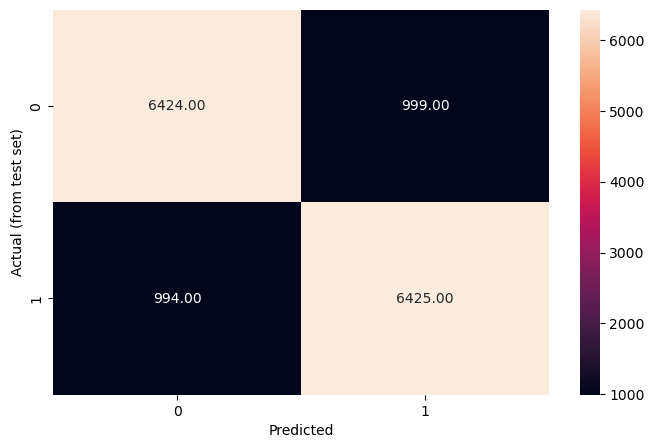


- against the train set:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     29681
           1       0.86      0.86      0.86     29685

    accuracy                           0.86     59366
   macro avg       0.86      0.86      0.86     59366
weighted avg       0.86      0.86      0.86     59366
 



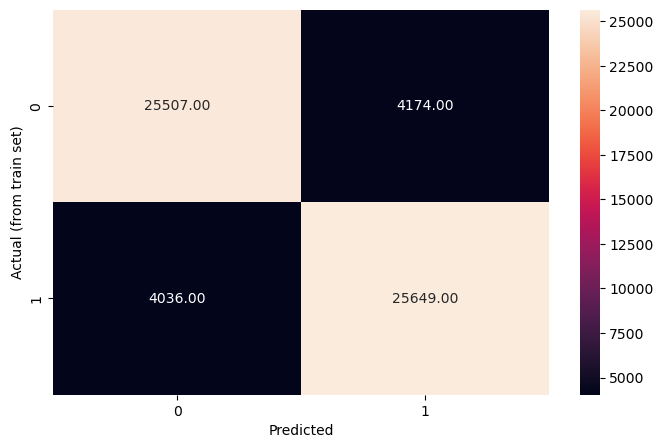


MODEL REPORT:  DecisionTreeClassifier(max_depth=6, min_samples_split=3, random_state=42) 
- against the test set:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      7423
           1       0.89      0.88      0.89      7419

    accuracy                           0.89     14842
   macro avg       0.89      0.89      0.89     14842
weighted avg       0.89      0.89      0.89     14842
 



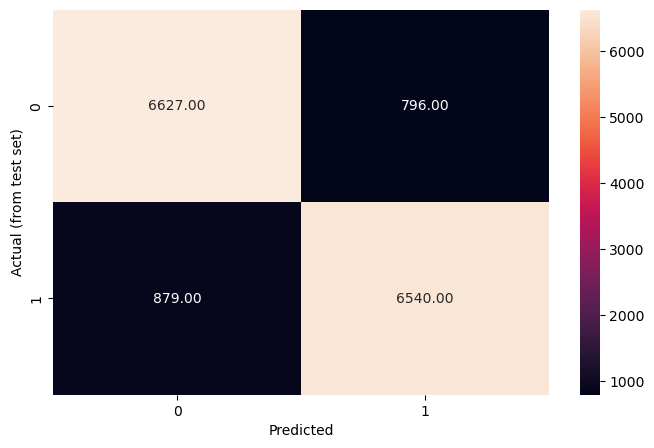


- against the train set:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89     29681
           1       0.89      0.89      0.89     29685

    accuracy                           0.89     59366
   macro avg       0.89      0.89      0.89     59366
weighted avg       0.89      0.89      0.89     59366
 



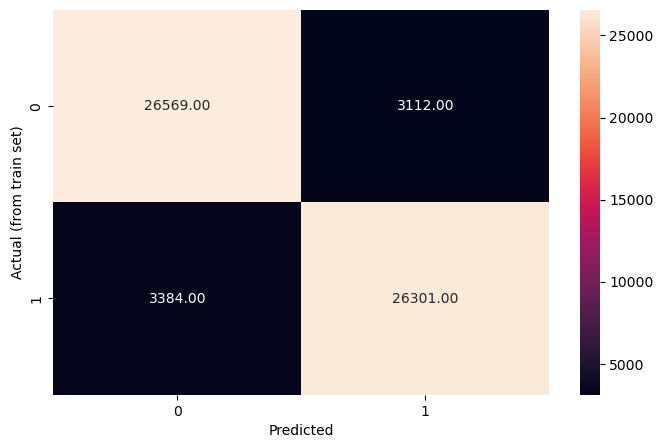


MODEL REPORT:  RandomForestClassifier(max_depth=6, min_samples_split=5, n_estimators=30,
                       random_state=42, warm_start='True') 
- against the test set:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      7423
           1       0.90      0.94      0.92      7419

    accuracy                           0.92     14842
   macro avg       0.92      0.92      0.92     14842
weighted avg       0.92      0.92      0.92     14842
 



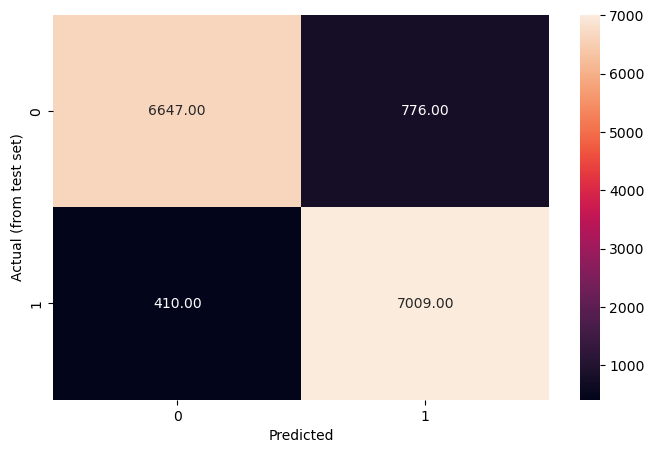


- against the train set:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92     29681
           1       0.90      0.95      0.92     29685

    accuracy                           0.92     59366
   macro avg       0.92      0.92      0.92     59366
weighted avg       0.92      0.92      0.92     59366
 



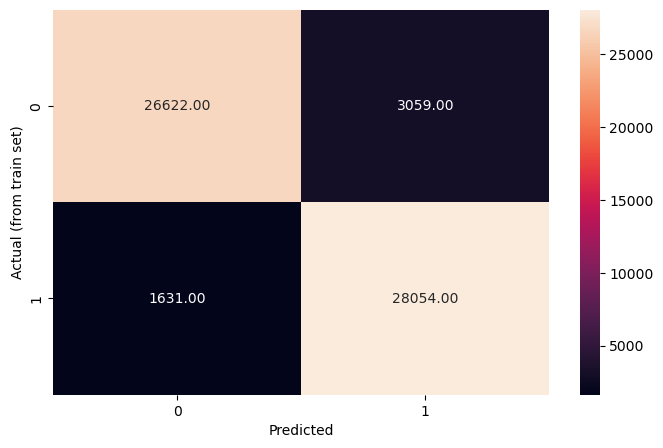


MODEL REPORT:  KNeighborsClassifier() 
- against the test set:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      7423
           1       0.91      0.93      0.92      7419

    accuracy                           0.92     14842
   macro avg       0.92      0.92      0.92     14842
weighted avg       0.92      0.92      0.92     14842
 



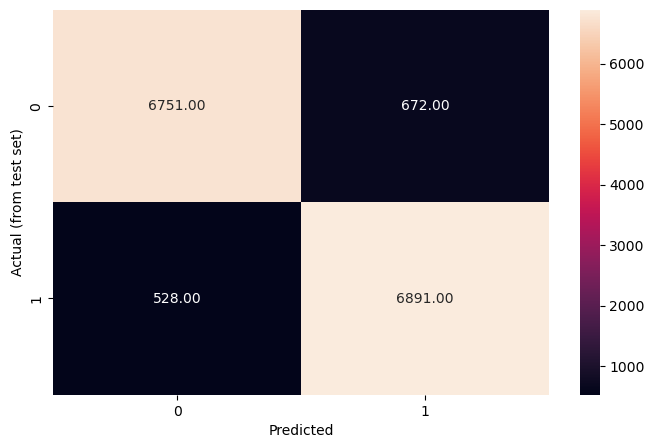


- against the train set:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     29681
           1       0.93      0.95      0.94     29685

    accuracy                           0.94     59366
   macro avg       0.94      0.94      0.94     59366
weighted avg       0.94      0.94      0.94     59366
 



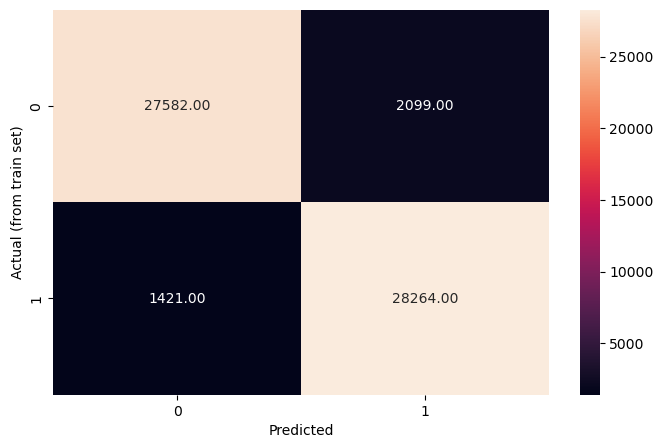


MODEL REPORT:  SVC(C=0.1, random_state=42) 
- against the test set:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      7423
           1       0.87      0.89      0.88      7419

    accuracy                           0.88     14842
   macro avg       0.88      0.88      0.88     14842
weighted avg       0.88      0.88      0.88     14842
 



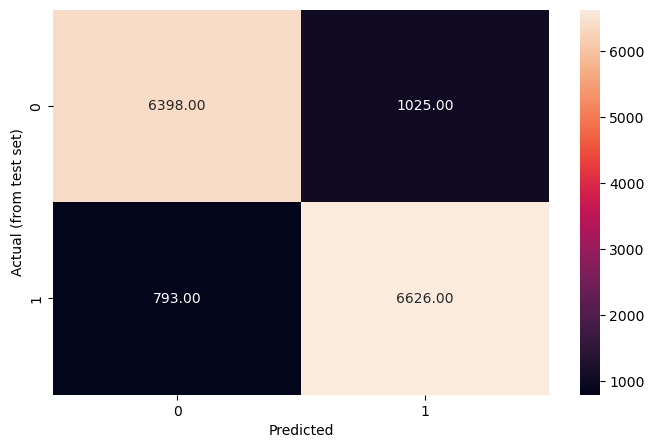


- against the train set:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88     29681
           1       0.87      0.90      0.88     29685

    accuracy                           0.88     59366
   macro avg       0.88      0.88      0.88     59366
weighted avg       0.88      0.88      0.88     59366
 



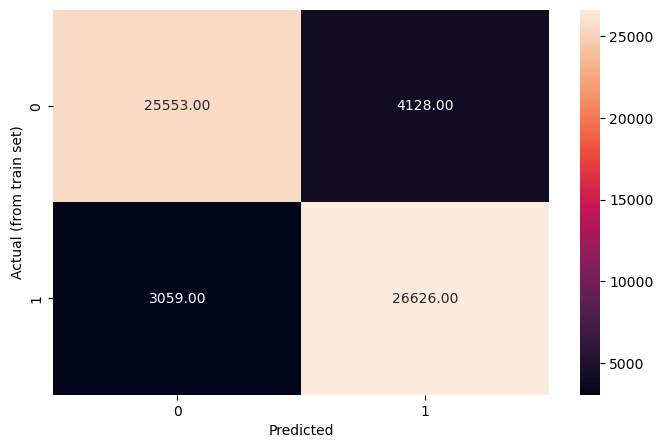

In [33]:
dict_models = {}
for model in models:
    if model != 'XGBClassifier':
        estimator = load_model(model)
        gs = GridSearchCV(estimator = estimator, param_grid = param_grid[model])
        gs.fit(X_train_stand, y_train)
        dict_models[model] = gs.best_estimator_
        y_pred_test = dict_models[model].predict(X_test_stand)
        y_pred_train = dict_models[model].predict(X_train_stand)
        print("\nMODEL REPORT: ", dict_models[model],
              "\n- against the test set:\n", classification_report(y_test, y_pred_test),
              "\n")
        confusion_matrix_plot(y_test, y_pred_test, test_set=True)
        plt.savefig('../src/visualization/' + str(dict_models[model]) + '_against_test.pdf')
        plt.show(), plt.close()
        print("\n- against the train set:\n", classification_report(y_train, y_pred_train),
              "\n")
        confusion_matrix_plot(y_train, y_pred_train, test_set=False)
        plt.savefig('../src/visualization/' + str(dict_models[model]) + '_against_train.pdf')
        plt.show(), plt.close()
    else: continue

[14:37:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_depth", "sampling_method" } are not used.

[14:37:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_depth", "sampling_method" } are not used.

[14:37:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_depth", "sampling_method" } are not used.

[14:37:47] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_depth", "sampling_method" } are not used.

[14:37:48] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "max_depth", "samp

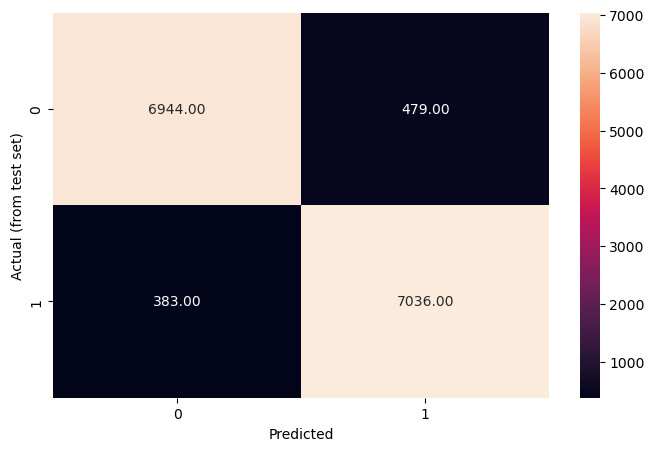


- against the train set:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     29681
           1       0.95      0.96      0.95     29685

    accuracy                           0.95     59366
   macro avg       0.95      0.95      0.95     59366
weighted avg       0.95      0.95      0.95     59366
 



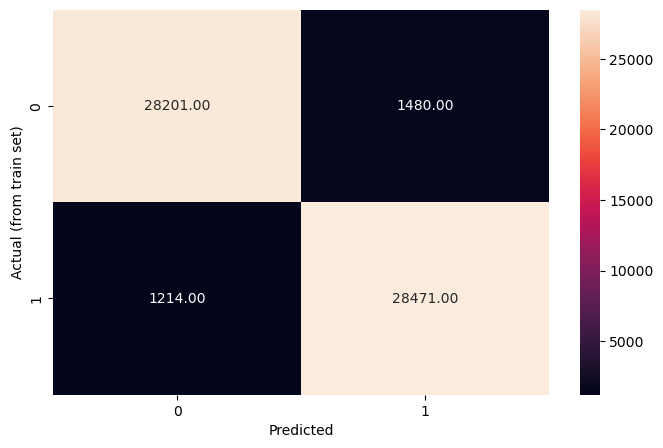

In [40]:
# hyperparameter tuning for the XGB classifier only

for model in models:
    if model == 'XGBClassifier':
        estimator = load_model(model)
        gs = GridSearchCV(estimator = estimator, param_grid = param_grid[model])
        gs.fit(X_train_stand, y_train)
        dict_models[model] = gs.best_estimator_
        y_pred_test = dict_models[model].predict(X_test_stand)
        y_pred_train = dict_models[model].predict(X_train_stand)
        print("\nMODEL REPORT: ", dict_models[model],
              "\n- against the test set:\n", classification_report(y_test, y_pred_test),
              "\n")
        confusion_matrix_plot(y_test, y_pred_test, test_set=True)
        plt.savefig('../src/visualization/' + str(model) + '_against_test.pdf')
        plt.show(), plt.close()
        print("\n- against the train set:\n", classification_report(y_train, y_pred_train),
              "\n")
        confusion_matrix_plot(y_train, y_pred_train, test_set=False)
        plt.savefig('../src/visualization/' + str(model) + '_against_train.pdf')
    else: continued

In [75]:
accuracy_report = {}
for model, parameter in dict_models.items():
    y_pred_test = parameter.predict(X_test_stand)
    y_pred_train = parameter.predict(X_train_stand)
    report = classification_report(y_test, y_pred_test, output_dict=True)
    accuracy_report[model] = {'f1_class0': report['0']['f1-score'], 'f1_class1': report['1']['f1-score'], 'overall accuracy': report['accuracy']}

accuracy_report_pd = pd.DataFrame.from_dict(f1_report).round(2)
accuracy_report_pd

,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,KNeighborsClassifier,SVC,XGBClassifier
f1_class0,0.87,0.89,0.92,0.92,0.88,0.94
f1_class1,0.87,0.89,0.92,0.92,0.88,0.94
overall accuracy,0.87,0.89,0.92,0.92,0.88,0.94


All models reached f1 and accuracy scores above the target threshold (>= 81%). In particular, the `XGBClassifier` reached an impressive result: 94% for both the f1-scores of both classes, and the overall accuracy. 

The `XGBClassifier` algorithm also revealed that, out of all the features considered, having an house loan plays a major role in leading clients to buy the term deposition subscription. Other features that play an equal role in this are (in this order): the existence of personal loan, contact communication type, the month in which clients were last contacted, their marital status, and duration of the last contact. Finally, the number of contacts performed during the campaign does not seem to be as effective.

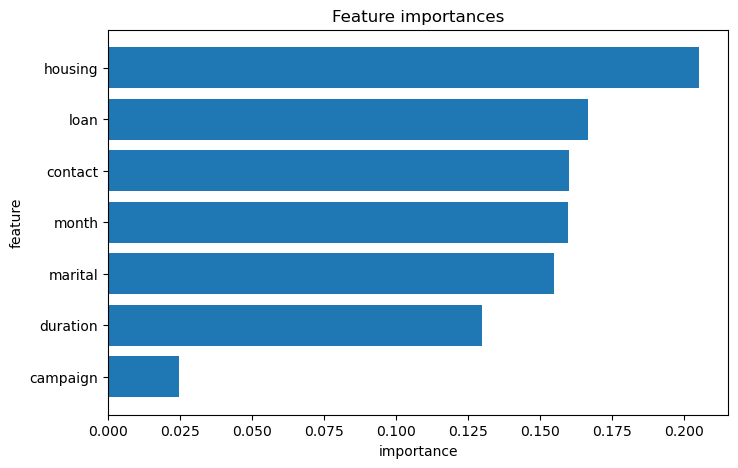

In [72]:
feature_names = list(X_train_stand.columns)
feature_imp = dict_models['XGBClassifier'].feature_importances_
feature_imp_indices = np.argsort(feature_imp)

plt.figure(figsize=(8, 5))
plt.title("Feature importances")
plt.barh(range(len(feature_imp_indices)), feature_imp[feature_imp_indices])
plt.xlabel("importance")
plt.yticks(range(len(feature_imp_indices)), [feature_names[i] for i in feature_imp_indices])
plt.ylabel("feature")
plt.savefig('XGB_FeatureImportance.pdf')

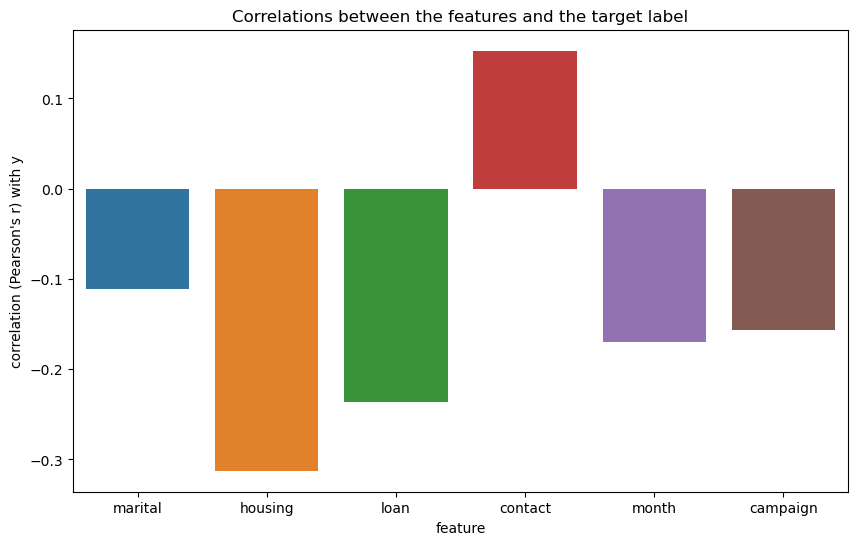

In [73]:
data_train_stand = pd.concat([X_train_stand, y_train], axis=1)
data_test_stand = pd.concat([X_test_stand, y_test], axis=1)
data_stand = pd.concat([data_train_stand, data_test_stand], axis=0)

corr_final = pd.DataFrame(data_stand.corr().y).drop('duration', axis=0)[:-1]
plt.figure(figsize = (10,6))
sns.barplot(x = corr_final.index, y = corr_final.y)
plt.title("Correlations between the features and the target label")
plt.xlabel("feature"), plt.ylabel("correlation (Pearson's r) with y")
plt.savefig('XGB_Correlations.pdf')

In particular, four of the six most important features (`housing`, `loan`, `month`, `marital`) are shown to negatively correlation with the success rate for subscriptions to the deposit. Only `contact` and `duration` (i.e., the number of contacts performed during the campaign) seem to have a mild positive correlation with it.  This suggest that segment(s) of customers to prioritize may be single, and not holding any housing or personal loan. Customers seem to prefer being contacted over their cellular phone, and get less and less predisposed to subscribe to the deposit as the year unfolds, so the client should consider focus their effort in the first quarters of the year.

N.B.: In the plot above, `duration` was dropped because it refers to the duration of the last contact. Unexpectedly, this would strongly correlate with the target label (*r*>0.5), since successful subscription would entail a longer time needed for the information exchange. 

# Conclusion

In this notebook, I showed how a few pre-processing steps (label encoding, data balancing, feature-selection, and standardization), and an effective grid search cross-validation technique are able to identify the best parameters that allowed the `XGB classifier` algorithm to reach remarkably high f-1 and accuracy scores -- more than 13% higher than the target value requested by the company.